<a href="https://colab.research.google.com/github/NastyaPorunova/gpb_test/blob/main/MOEX_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pyod

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 13.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.0.9-py3-none-any.whl size=184097 sha256=834a071bf5e1b6fc7fcd7190f0cfc2543aa095c740fe90aca3c15edd1ba1a26c
  Stored in directory: /root/.cache/pip/wheels/83/55/6b/552e083cf5509c0afe808b76cf434f1be284d01a112623bd37
Successfully built pyod


In [2]:
import time
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use({'figure.facecolor':'white'})

from sklearn.preprocessing import StandardScaler
from pyod.models.iforest import IForest

In [3]:
df = pd.read_csv('tradesMOEX.csv', sep=";") #считываем данные из файла
df = df.head(5051) #обрезаем некоторые строки состоящие из NaN  

In [4]:
df = df.drop(['TRADETIME_GRP', 'TRADETIME'], axis = 1) #удаляем признаки дублирующие SYSTIME

In [5]:
df

,TRADENO,BOARDID,SECID,PRICE,QUANTITY,VALUE,PERIOD,SYSTIME,BUYSELL,DECIMALS,TRADINGSESSION
0,4037738619,TQBR,MOEX,176.11,1.0,1761.1,S,2021-06-16 09:59:51,S,2.0,1.0
1,4037738620,TQBR,MOEX,176.11,1.0,1761.1,S,2021-06-16 09:59:51,S,2.0,1.0
2,4037738621,TQBR,MOEX,176.11,5.0,8805.5,S,2021-06-16 09:59:51,S,2.0,1.0
3,4037738622,TQBR,MOEX,176.11,4.0,7044.4,S,2021-06-16 09:59:51,S,2.0,1.0
4,4037738623,TQBR,MOEX,176.11,59.0,103904.9,S,2021-06-16 09:59:51,S,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
5046,4037919578,TQBR,MOEX,177.02,9.0,15931.8,N,2021-06-16 10:33:07,S,2.0,1.0
5047,4037919579,TQBR,MOEX,177.02,25.0,44255.0,N,2021-06-16 10:33:07,S,2.0,1.0
5048,4037919580,TQBR,MOEX,177.02,1.0,1770.2,N,2021-06-16 10:33:07,S,2.0,1.0
5049,4037919604,TQBR,MOEX,176.99,1.0,1769.9,N,2021-06-16 10:33:07,S,2.0,1.0


In [6]:
#переводим данные со временем в нужный формат
df['SYSTIME'] = pd.to_datetime(df['SYSTIME'], format='%Y-%m-%d %H:%M:%S')

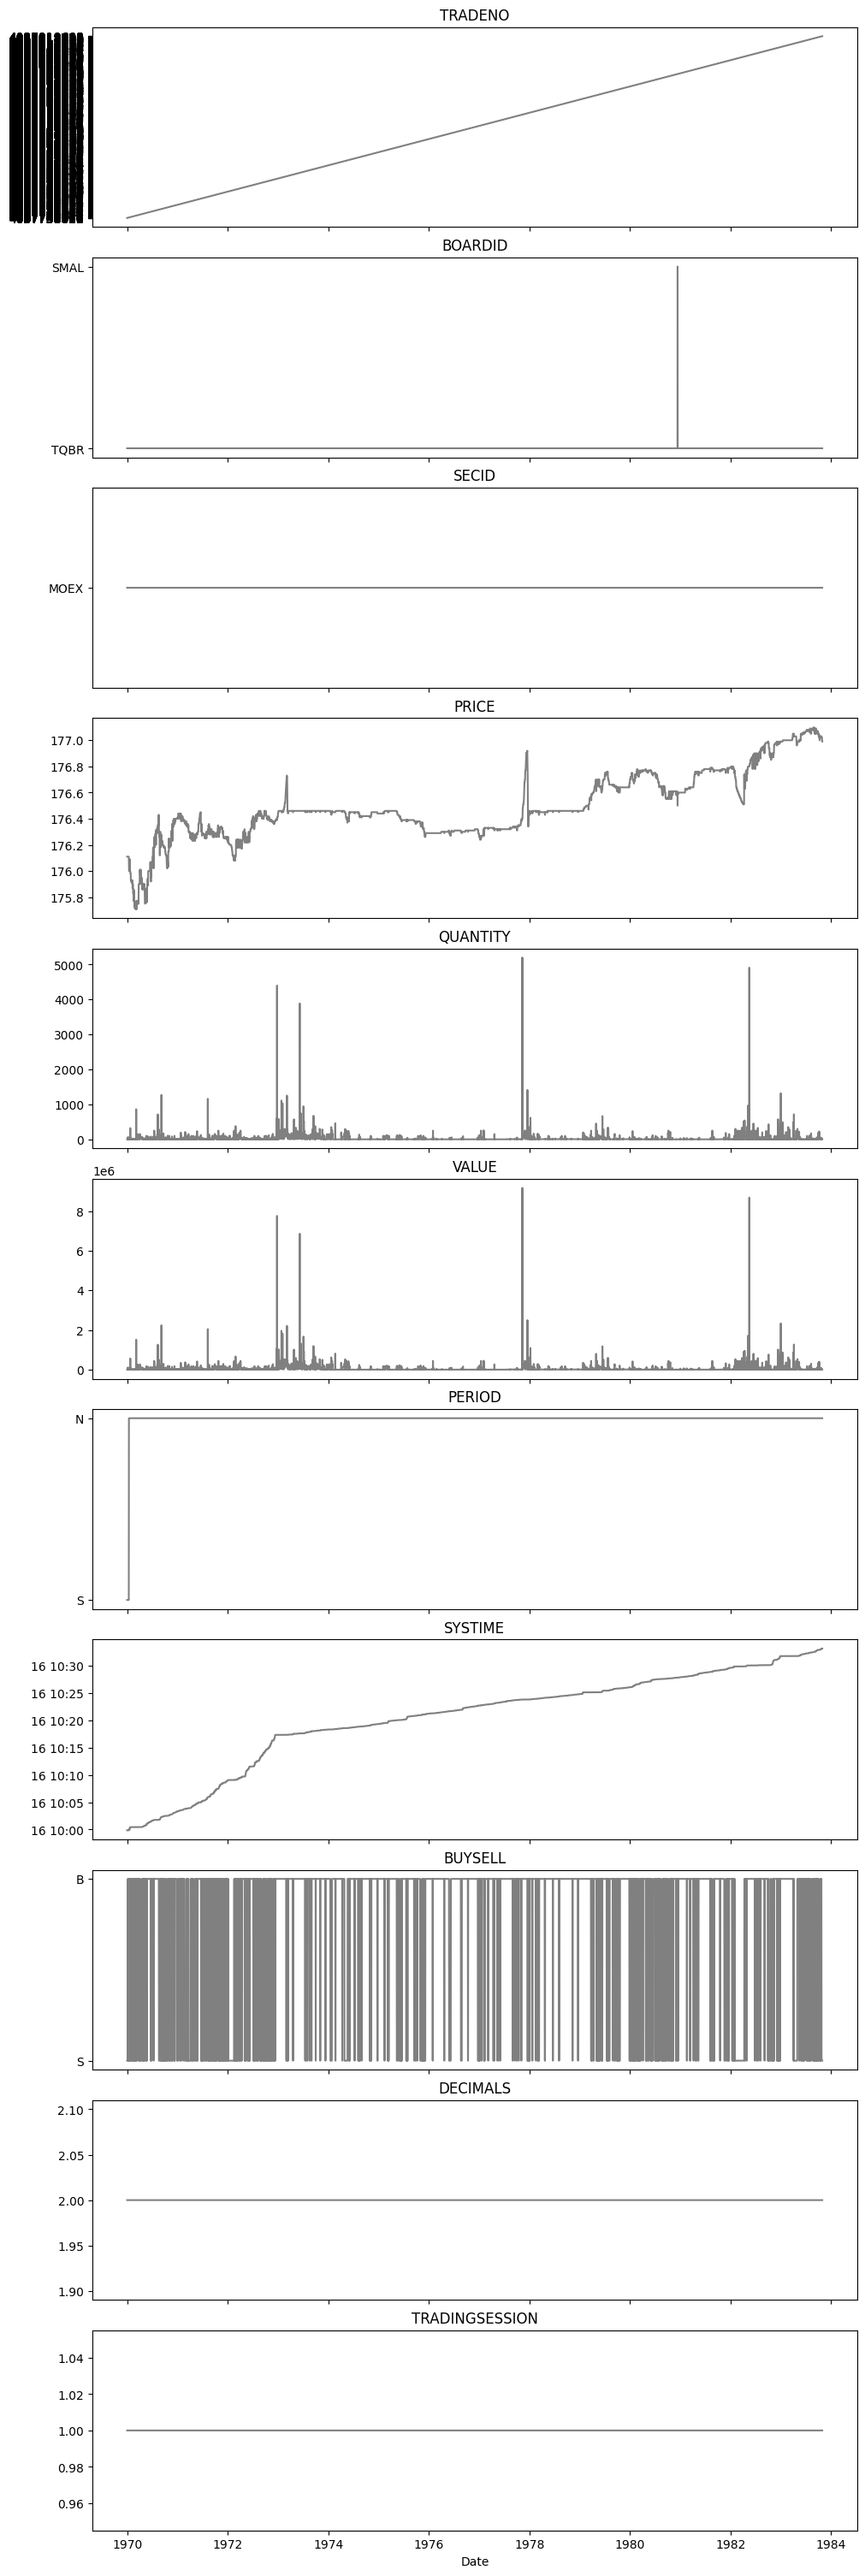

In [7]:
def show_plots(df, columns, anomaly_column=None):
    fig, axs = plt.subplots(len(columns), 1, sharex=True, constrained_layout=True, figsize=(10,30))
    for i in range(len(columns)):
        c = columns[i]

        axs[i].plot(df.index, df[c], color='gray',label='Normal')

        if anomaly_column:
            a = df.loc[df[anomaly_column] == 1, [c]] #anomaly
            axs[i].scatter(a.index, a[c], color='red', label='Anomaly')

        axs[i].xaxis_date()
        axs[i].set_title(c)
        plt.xlabel('Date')
    plt.show()

columns = df.columns
show_plots(df, columns)

In [8]:
df = df.set_index('SYSTIME')#устанавливаем новый индекс

#таким образом от времени не зависят некоторые столбцы и мы можем их удалить
TRADENO_data = df['TRADENO'].copy(deep = True) #сохраняем 
df = df.drop(['TRADENO', 'TRADINGSESSION', 'DECIMALS', 'SECID'], axis = 1) 

columns = df.columns

In [9]:
#делаем данные категориальными
cleanup_nums = {'TQBR': 1, 'SMAL': 0}
df['BOARDID'] = df['BOARDID'].map(cleanup_nums).astype('float')

cleanup_nums = {'N': 1, 'S': 0}
df['PERIOD'] = df['PERIOD'].map(cleanup_nums).astype('float')

cleanup_nums = {'B': 1, 'S': 0}
df['BUYSELL'] = df['BUYSELL'].map(cleanup_nums).astype('float')

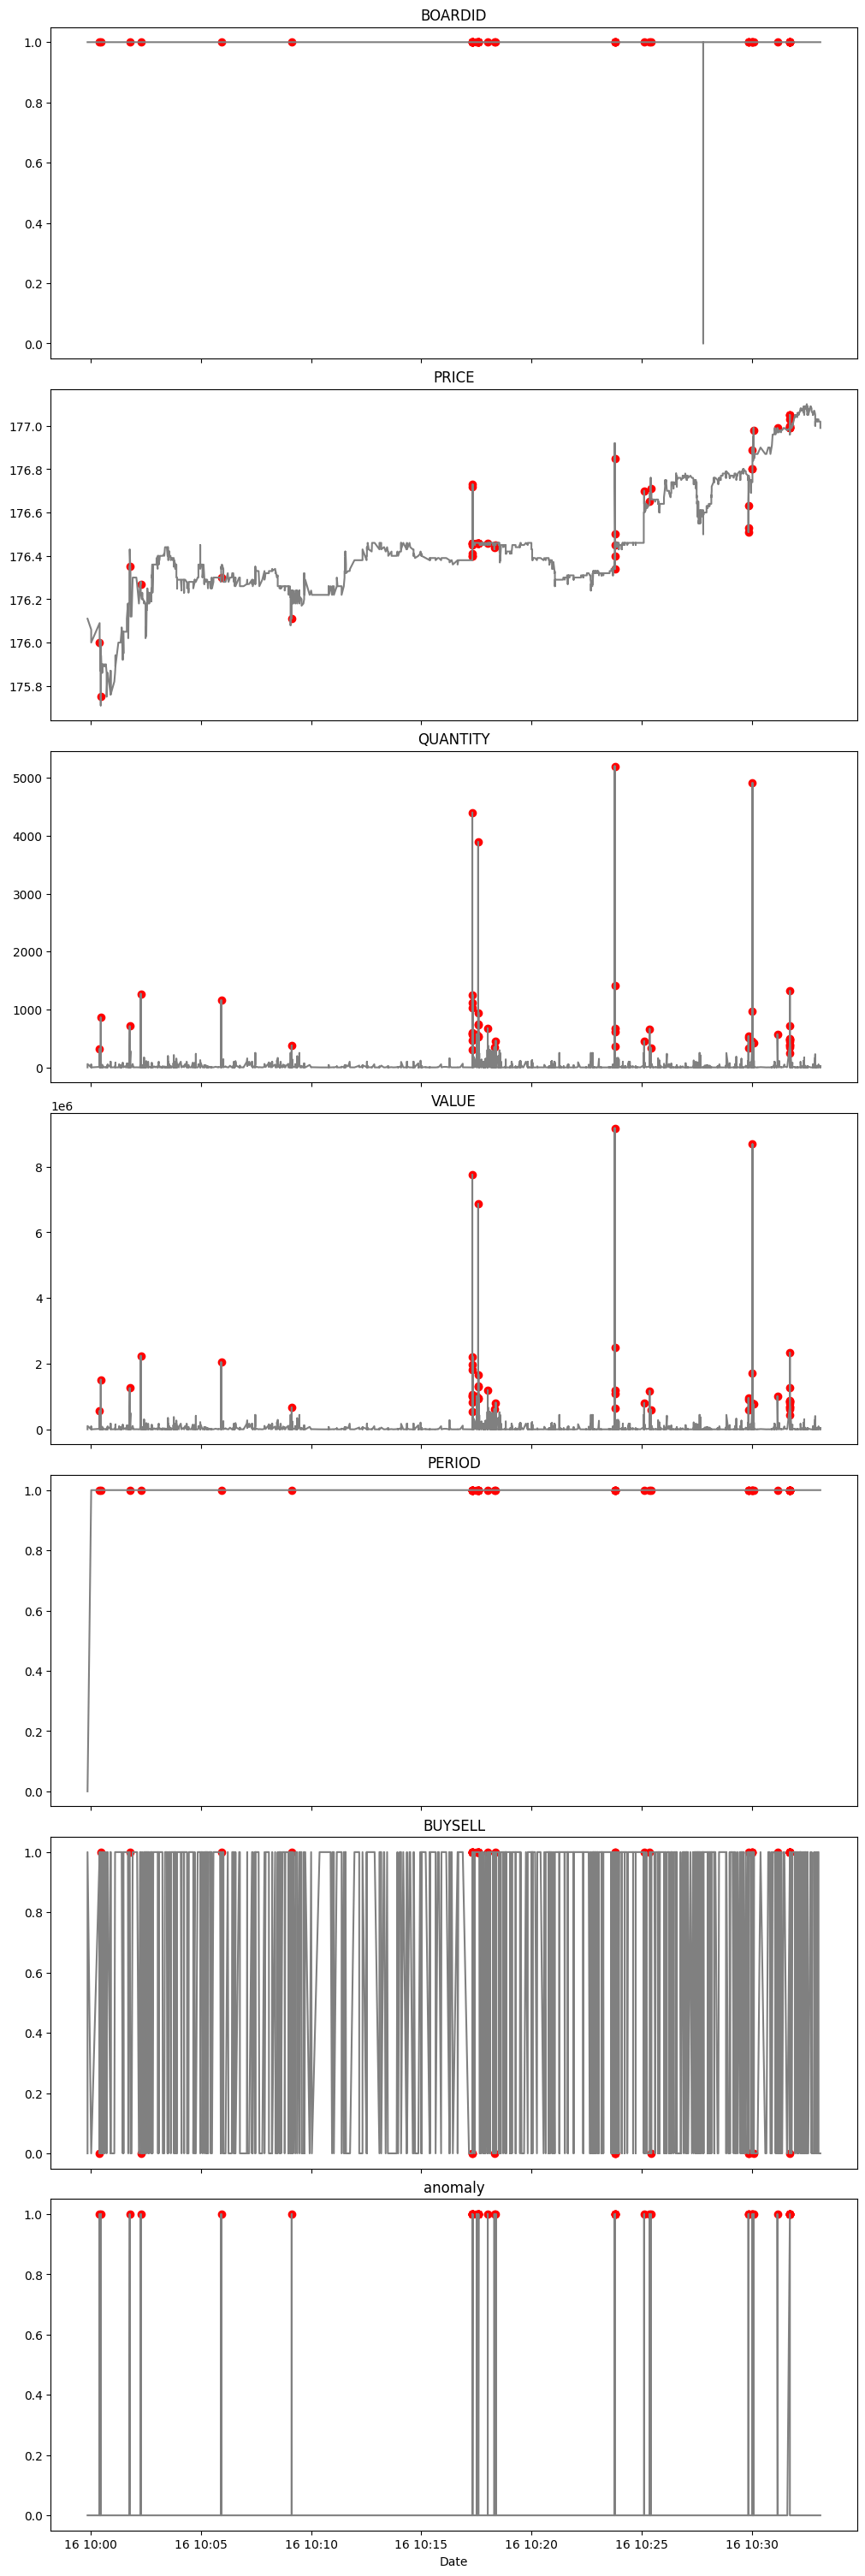

In [15]:
random_state = np.random.RandomState(42) #устанавливаем значение для воспроизводимости результатов

#установим конкретное значение доли аномалий в данных
outliers_fraction = 0.01 #установим долю аномалий на самый низкий порог в диапазоне (0, 0.5]

if_detector = IForest(contamination = outliers_fraction, random_state=random_state)

X = df.values
if_detector.fit(X) 

pred = if_detector.predict(X) 
df['anomaly'] = pred

columns = df.columns
show_plots(df, columns, 'anomaly')

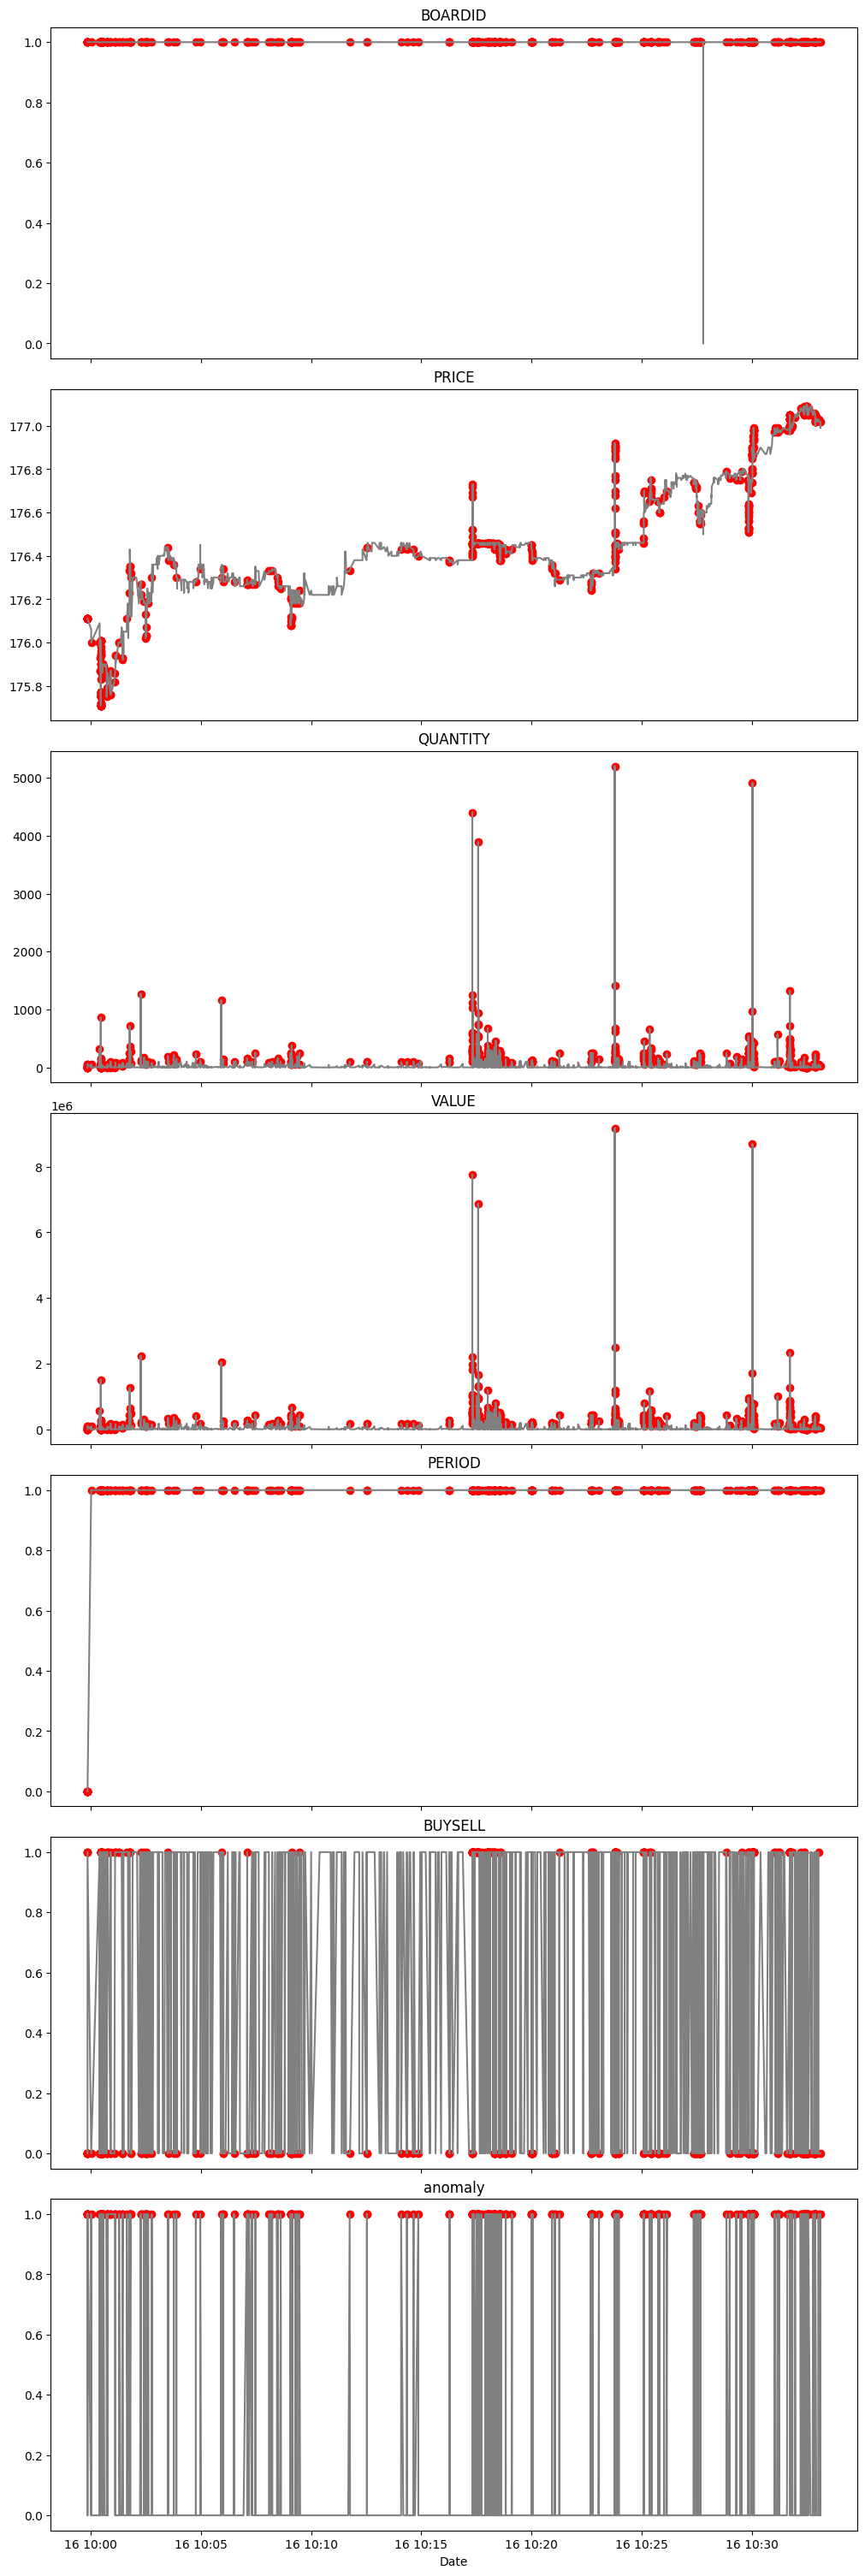

In [16]:
#построим модель без явного указания доли аномальных данных

if_detector = IForest(random_state=random_state)

X = df.values
if_detector.fit(X) 

pred = if_detector.predict(X) 
df['anomaly'] = pred

columns = df.columns
show_plots(df, columns, 'anomaly')

In [17]:
print("Процент аномалий в данных: {:.2f}".format((len(df.loc[df['anomaly']==1])/len(df))*100))

Процент аномалий в данных: 10.00


In [19]:
#создаём DataFrame с подозрительными операциями, выявленными последней моделью 
new_df = df[['anomaly']].copy(deep = True)
new_df.insert(1, "TRADENO", TRADENO_data)

suspicious_transactions = new_df[new_df['anomaly'] == 1].drop('anomaly', axis = 1).reset_index()
suspicious_transactions

,SYSTIME,TRADENO
0,2021-06-16 09:59:51,4037738619
1,2021-06-16 09:59:51,4037738620
2,2021-06-16 09:59:51,4037738621
3,2021-06-16 09:59:51,4037738622
4,2021-06-16 09:59:51,4037738623
...,...,...
500,2021-06-16 10:32:53,4037918795
501,2021-06-16 10:32:53,4037918802
502,2021-06-16 10:32:53,4037918803
503,2021-06-16 10:33:02,4037919230
